<a href="https://colab.research.google.com/github/sgangoly/General-Relativity/blob/master/LIGO_GW/GW_Ligo_Ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3'
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

In [0]:
%matplotlib inline
import numpy
import pylab
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.filter import highpass_fir, matched_filter
from pycbc.psd import welch, interpolate

In [2]:
# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

--2020-06-04 15:46:37--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf.2’

challenge2.gwf.2    100%[===================>]   3.84M  7.88MB/s    in 0.5s    

2020-06-04 15:46:38 (7.88 MB/s) - ‘challenge2.gwf.2’ saved [4025842/4025842]



In [0]:
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
pyd = pycbc_strain

In [4]:
from gwpy.timeseries import TimeSeries
ts1 = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")
print (ts1)

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)


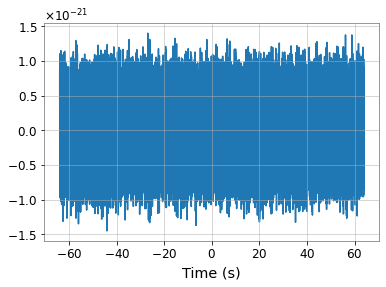

In [6]:
pylab.plot(pyd.sample_times, ts1)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
from gwpy.timeseries import TimeSeries

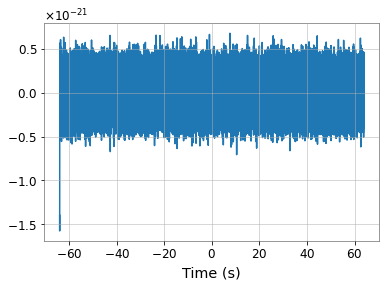

In [17]:

# Remove the low frequency content and downsample the data to 2048Hz
pyd = highpass(pyd, 15.0)
pyd = resample_to_delta_t(pyd, 1.0/2048)

pylab.plot(pyd.sample_times, pyd)
pylab.xlabel('Time (s)')
pylab.show()

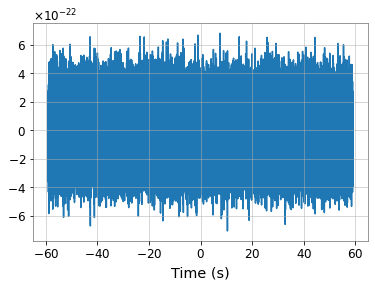

In [24]:
conditioned = pyd.crop(5, 5)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

Text(0, 0.5, 'Strain')

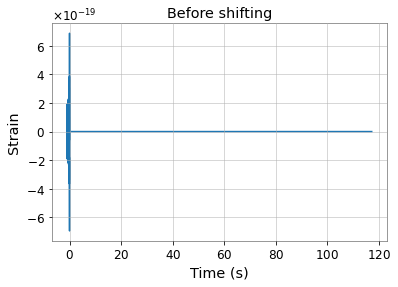

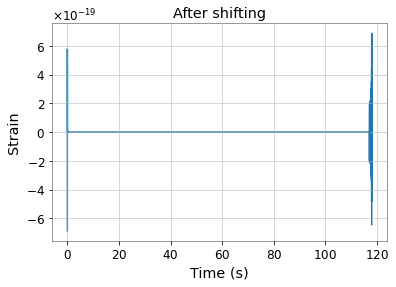

In [28]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

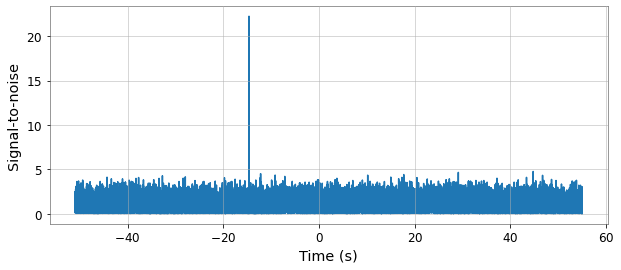

We found a signal at -14.6328125s with SNR 22.242440596992587


In [29]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

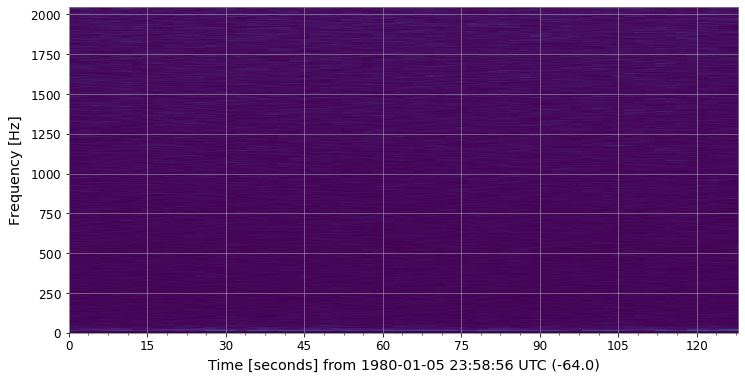

In [9]:
specgram = ts1.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

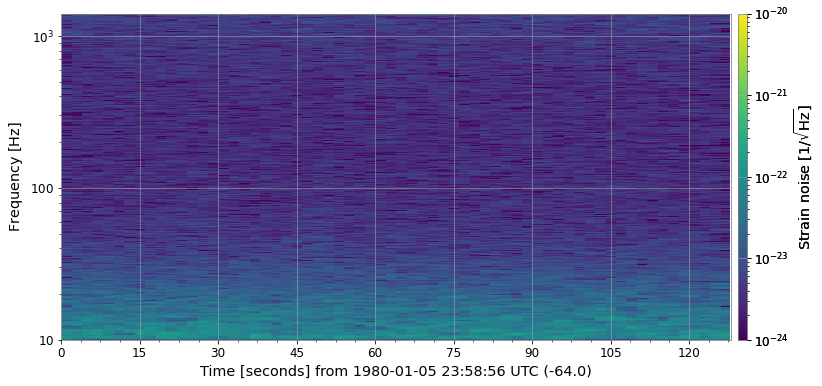

In [11]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

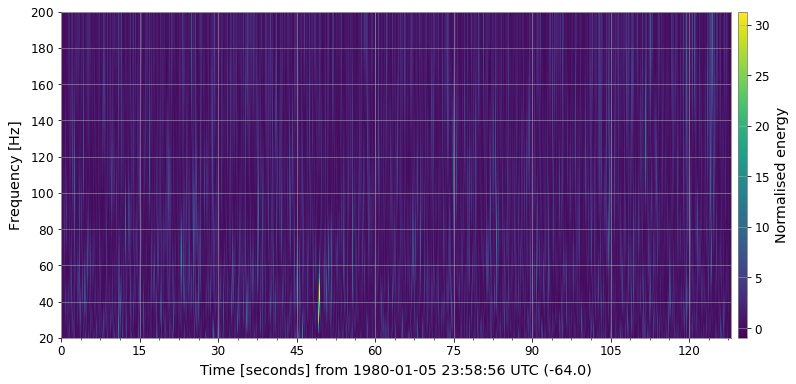

In [12]:
hq1 = ts1.q_transform(frange=(20, 200))
plot = hq1.plot()
plot.colorbar(label="Normalised energy")